# Intro to Machine Learning with Meteorological Station Data: Part 2
__Constructed and written by Eleanor Middlemas  
Updated April 2022  
*eleanor at jupiterintel.com*__

Part 2) __Supervised Learning: Relationship assessment & feature importance.__ <br>
Which variable in the Christman data is the best predictor of rainfall? <br><br>
[Part A) Building a model to predict rainfall likelihood](#Building-a-model-to-predict-rainfall-likelihood) <br>Create a model that best captures the relationship between meteorological variables and rainfall likelihood. <br><br>
[Part B) Using our new model to determine best rainfall predictor](#Feature-Importance) <br> Learn how to utilize scikit-learn's *feature importance* tool as an alternative to linear regression.<br><br>
[Part C) Post-lab Questions](#Questions)<br><br>

__The goals of Part 2 of this Application Lab are to:__<br>
1. Be exposed to a swath of supervised learning algorithms and have some ML algorithm code as a reference for later use.<br>
2. Walk away with some understanding of two uses of supervised learning algorithms: prediction and feature importance.<br>
3. Become familiar with the data processing pipeline required to utilize supervised learning techniques.<br>
4. Learn more vocabulary and building a foundation for future google searches: cross-validation, training v. testing data, metrics (accuracy, recall, precision, f1 score, etc), overfitting/underfitting, balancing datasets, hyperparameters, & feature importance.<br><br>

In the first section of Part 2, much like Part 1 of the application lab, we are building and training models to predict something we already know from the dataset--in this case, whether it's raining or not. Given your intuition about rainfall, you can devote more brainpower into analyzing the algorithms provided.<br><br>


# Part 0. Read in data into a pandas dataframe.

*This is the same code used in Part 1 of the Application Lab.*

In [8]:
import pandas as pd
import numpy as np
import datetime
import time

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---------------------------------------------

# Part 2. Supervised learning

#### We will be using supervised learning methods to perform the following two tasks:
1. Predict the likelihood of rainfall given certain atmospheric conditions
    1. Prepping the data
    2. Building and training models
        1. Logistic regression
        2. Random Forest
        4. Neural Network
2. Determine which variable ("feature") is the best predictor of rainfall, i.e., "feature importance"

---------------------------------------------

# 2.1. Building a model to predict rainfall likelihood

Let's say you want to determine which features or atmospheric variables are the best predictors of rainfall in Christman, CO. <br><br>
Often, one simply regresses some metric of precipitation onto various atmospheric variables, and assume that whatever returns the highest regression coefficient is the best predictor. <br><br>
While linear regression presents a fine first guess, it poses a few problems. Linear regression assumes atmospheric variables are linearly related to precipitation, AND that atmospheric variables are not collinear (both of which are false assumptions). <br><br>
While a linear relationship between predictor & predictand is a good first guess, why limit yourself to linearity when you can just as easily relax that assumption?<br><br>
This is where Machine Learning can come in handy. The rest of this notebook will step through the following Machine Learning model pipeline:<br><br>

![model_pipeline](https://drive.google.com/uc?export=view&id=1ZvJXnqUz89UjkbSjUK18QGM0ctQP3b9o)

---------------------------------------------

# 2.1.B. Data Preparation

Data preparation is a huge part of building Machine Learning model "pipelines".

There are few steps involved when thinking about building & training a Machine Learning model. Remember, models are "stupid", and there are a few statistical "gotcha's" that may result in your model being biased, inaccurate, or not suitable for the problem at hand. The order of addressing these issues in your data is important (we will address the importance of this order in question 1 at the end)!
<br>
1. __What exactly are we trying to predict? A value, an outcome, a category? Define your predictors and predictand.__ This requires revisiting your hypothesis or overarching question. In our case, our predictand is the likelihood of precipitation. We will build a Machine Learning model (actually, a few models) that predicts the likelihood that it's currently precipitating at Christman, CO, given current atmospheric conditions. 
<br><br>
2. __Do you have any missing data? If so, how will you handle them? Keep in mind, decreasing the number of input observations may bias your model.__ In our case, we have no missing data.
<br><br>
3. __Do you have any categorical or non-numeric variables or features? If so, you must figure out how to encode them into numbers.__ Luckily, in the geosciences, we rarely run into this problem.
<br><br>
4. __How will we validate our model?__ Typically, people split their existing data into training data and testing data, or perform "__cross-validation__" or a "__test-train split__". That is, we will "hold out" some data and call it our "testing data", while using the rest of the data to train our model (i.e., "training data"). Once our model is trained, we will evaluate its performance with the holdout testing data. *Note:* This could be problematic if there is limited data. 
<br><br>
5. __Do your features have the same variance?__ Just like for K-means clustering above, this can be an important step so that your model doesn't overemphasize one variable with large variance too much. This step is called "__feature scaling__". Features of the same size also speed up the Gradient Descent algorithm. For some algorithms, like Linear Regression and Random Forest, feature scaling doesn't matter. But for algorithms like Neural Networks, this becomes very important.
<br><br>
6. __If classification is the goal, are there the same number of observations for each feature and outcome? If not, how will you rebalance?__ Luckily, we have the same number of observations (8784) for each feature, but a lack of precipitation is way more common than hours with precipitation. We will oversample the observations associated with precip so that the two outcomes (or "classes") are equal, though we are making a big assumption: that our subsample is a good representation of each feature distribution. Otherwise, we are building a model that represents unrealistic distributions and thus their respective relationships. *Note: It's important that feature scaling or normalization is performed before any rebalancing so that the qualitative statistics (mean, stddev, etc) remain the same.*
<br><br>
7. __What are the appropriate metrics for assessing your model? Consider the bias-variance trade-off, and whether having false positives or false negatives is more impactful.__ In our case, predicting no rain when there is rain (false negative) is probably more frustrating and potentially more impactful than the other way around (a false positive). The same can be said for regression models: but metrics computing the model & prediction error are more important (RMSE, R$^2$, MAE, percent error, etc.)

<br>

In [9]:
import pandas as pd
import numpy as np
import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


### Q1. What exactly are you trying to predict?
First, split data into predictor & predictands. 
I'm going to create (or "engineer") a new feature that indicates whether precipitation occurred. Clearly, this step only needs to be performed once.

In [10]:
df = pd.read_csv("/content/drive/MyDrive/ATOC5860/ATOC5860_Spring2022_share/applicationlab6/christman_2016.csv")
df.columns # what is the variable called that indicates precipitation amount?

Index(['day', 'hour', 'temp_F', 'RH', 'dewtemp_F', 'wind_mph', 'wind_dir',
       'windgust', 'windgust_dir', 'pres_Hg', 'SOLIN_Wm2', 'Prec_inches'],
      dtype='object')

In [11]:
df['prec_occur'] = np.array(df.Prec_inches!=0).astype(int)
df.sample(15) # randomly select & display 15 samples from the dataframe

,day,hour,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,Prec_inches,prec_occur
7855,42697,0.291667,21.8,83.0,17.5,1.9,326,5.3,346,844.45,0.9,0.00,0
6415,42637,0.291667,42.3,75.5,35.1,3.8,146,12.0,78,840.22,85.0,0.00,0
4850,42572,0.083333,63.8,67.5,52.8,1.5,324,5.6,303,845.66,0.0,0.00,0
1436,42429,0.833333,44.5,19.6,5.4,19.8,328,33.3,303,839.83,0.0,0.00,0
7754,42693,0.083333,19.3,73.9,12.3,8.7,303,10.8,312,850.72,0.0,0.00,0
5266,42589,0.416667,72.4,53.1,54.4,3.1,93,8.0,104,836.32,620.1,0.00,0
4922,42575,0.083333,62.6,63.1,49.9,3.5,301,9.3,277,844.33,0.1,0.00,0
3549,42517,0.875000,49.5,71.4,40.6,8.4,263,13.3,307,839.66,0.1,0.01,1
1921,42450,0.041667,32.4,58.3,19.4,2.5,7,7.0,242,841.36,0.0,0.00,0
2360,42468,0.333333,49.2,40.6,26.3,1.2,115,3.2,247,847.61,310.0,0.00,0


Then, select the data that will be predictors. 

In [12]:
predictors = df.copy(deep=True) 
# deep = True so that changes to predictors won't be made to original df.

# these shouldn't go into predicting whether or not there is rain.
predictors = df.drop(['day','hour','Prec_inches'],axis=1) 
predictors

,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,prec_occur
0,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0,0
1,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0,0
2,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0,0
3,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0,0
4,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0,0
...,...,...,...,...,...,...,...,...,...,...
8779,22.3,74.3,15.4,0.9,221,3.3,202,833.32,0.0,0
8780,20.3,80.4,15.3,0.6,279,2.9,279,833.45,0.1,0
8781,19.9,81.1,15.1,0.5,197,2.5,279,833.01,0.1,0
8782,17.8,82.8,13.5,2.0,353,4.8,352,832.78,0.1,0


Great, that worked. Now I will assign everything but "prec" to be the predictor array "x", and prec will be the predictand vector "y".

In [13]:
x = predictors.drop('prec_occur',axis=1)
y = predictors.prec_occur
x

,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2
0,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0
1,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0
2,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0
3,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0
4,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0
...,...,...,...,...,...,...,...,...,...
8779,22.3,74.3,15.4,0.9,221,3.3,202,833.32,0.0
8780,20.3,80.4,15.3,0.6,279,2.9,279,833.45,0.1
8781,19.9,81.1,15.1,0.5,197,2.5,279,833.01,0.1
8782,17.8,82.8,13.5,2.0,353,4.8,352,832.78,0.1


In [14]:
y # should be a pandas series (type: pd.Series) - this or numpy.1DArray is usually the type required for scikit-learn.
  # be careful if you use a pd.Series because the index becomes important! Indexing can be useful but has also caused me many headaches.

0       0
1       0
2       0
3       0
4       0
       ..
8779    0
8780    0
8781    0
8782    0
8783    0
Name: prec_occur, Length: 8784, dtype: int64

### Q2 & Q3 do not need to be addressed in our dataset.

### Q4. How will you validate your model?

Next, perform a test-train split to ensure we can validate our trained model. <br>

This step must be performed before each time the model is trained to ensure we are not baking in any bias among the models we train. That also means the following two steps must also be performed prior to training each model as well. For this reason, I wrote functions to call easily before each model training.

*__Note__: Because we randomize our selection of data that we use to train the models, you may find slightly different model metrics, and thus, different answers than your neighbor. To circumference this and compare notes, input an integer for the variable* `random_state` *. Right now, it randomly selects one between 0 and 1000, but it can be any integer.*

In [15]:
from sklearn.model_selection import train_test_split
from random import randint

In [16]:
def define_holdout_data(
    x: pd.DataFrame,
    y: pd.Series,
    verbose: bool, 
    random_state: int="") -> tuple:
    """Perform a 80/20 test-train split (80% of data is training, 20% is 
    testing). Split is randomized with each call.
    
    :param x: a pandas dataframe containing all observations of the predictors
    of the dataset.
    :param y: a pandas series containing all observations of the predictands
    in the dataset.
    :param verbose: a boolean that is True if the user would like to print the
    variable shapes of the resulting datasets after splitting.
    :param random_state: (optional) an integer indicating the `random_state`
    of the splitting of the dataset. If not provided, some integer between 0
    and 1000 will randomly be chosen. User should provide if replicability
    is desired.

    :return: a tuple containing x & y, but split into training and testing
    data, respectively. (x_train, x_test, y_train, y_test)
    
    """
    if not random_state:
      random_state = randint(0,1000)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,
                                                        random_state=random_state)
    if verbose==True:
        print("Prior to scaling and rebalacing...")
        print("Shape of training predictors: "+str(np.shape(x_train)))
        print("Shape of testing predictors: "+str(np.shape(x_test)))
        print("Shape of training predictands: "+str(np.shape(y_train)))
        print("Shape of testing predictands: "+str(np.shape(y_test)))
        print(" ")
    return x_train, x_test, y_train, y_test

### Q5. Do your features have the same variance?

Now we must normalize the features, or perform "__Feature Scaling__", for the same reasons why we normalized prior to running the K-Means clustering algorithm. 
  
The difference here is that I will keep the data as a pandas dataframe rather than converting it to a numpy array beforehand. The "fit_transform" function outputs a numpy array, but we will convert back to a dataframe so that re-balancing the dataset is easier. 
  
*__Note__*: If my predictand wasn't binary, then I would also want to normalize that as well.

In [17]:
from sklearn import preprocessing

In [18]:
def scale_data(x_train: pd.DataFrame, x_test: pd.DataFrame) -> tuple:
    """
    Scale training data so that model reaches optimized weights much faster. 
    Scaling could mean standardizing (so that the standard deviation is 1) or 
    normalizing (the max and min are 1 and -1). Here we normalize.
    
    *All data that enters the model should use the same scaling used to scale 
    the training data.*
    Thus, we also perform scaling on testing data for validation later. 
    Additionally, we return the scalar used to scale any other future input 
    data.

    :param x_train: a pandas dataframe containing observations in the training
    dataset. Should have the same columns as `x_test`
    :param x_test: a pandas dataframe containing observations in the testing
    dataset. Should have the same columns as `x_train`
    :return: a tuple containing a MinMaxScaler object that will scale future 
    datasets in the same way, the scaled predictors from the training and 
    testing datasets (scaler, x_train_scaled, x_test_scaled).
    """
    
    scaler = preprocessing.MinMaxScaler() # normalize 
    x_train_scaled = pd.DataFrame(data=scaler.fit_transform(x_train),index=x_train.index,columns=x_train.columns) 
    x_test_scaled = pd.DataFrame(data=scaler.transform(x_test),index=x_test.index,columns=x_test.columns)
    
    return scaler, x_train_scaled, x_test_scaled

### Q6. Are there the same number of observations for each outcome or class?

Luckily, we have the same number of observations for each feature (8784). But do we have the same number of outcomes for our predictand - i.e., the same number of hours that are precipitating as those that are non-precipitating?

In [19]:
df['prec_occur'].value_counts()

0    8501
1     283
Name: prec_occur, dtype: int64

Definitely not. The outcomes we are trying to predict are extremely unbalanced. Non-precip hours occur 30x more than precip hours. This class imbalance may bias the model because precip hours are underrepresented, which means the model won't have as many instances of precip hours to learn to distinguish precip hours from non-precip hours. 

There are a number of out-of-the-box functions that resample data very precisely. The one I use below simply randomly copies the existing precipitating observation data to balance the dataset. <br><br>
There are a couple of risks associated with overfitting. For example, if your sample isn't a good representation of the larger distribution, you could be falsely representing relationships between samples. Additionally, if your minority case (i.e., precip days) are very rare, oversampling may increase the likelihood of occurring overfitting, since it makes copies of the minority class examples. Please see the [Wikipedia page](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) for some more guidance in your future Google search on resampling data.

*Note*: This function should be called on both training and testing data separately.

In [20]:
from sklearn.utils import resample

In [21]:
def balance_data(
    x: pd.DataFrame,
    y: pd.Series,
    verbose: bool,
    random_state:int = "") -> tuple:
    """
    Resample data ensure model is not biased towards a particular outcome of 
    precip or no precip.
    
    :param x: a pandas dataframe with rows of observations and columns 
    corresponding to predictors of rainfall.
    :param y: a pandas series indicating whether rainfall is happening.
    :param verbose: a boolean indicating whether printing resulting balanced
    dataset shapes is desired.
    :param random_state: (optional) an integer indicating the `random_state`
    of the splitting of the dataset. If not provided, some integer between 0
    and 1000 will randomly be chosen. User should provide if replicability
    is desired.

    :return: a tuple containing predictors and predictands with balanced 
    majority & minority classes.
    """
    # Combine again to one dataframe to ensure both the predictor and predictand are resampled from the same 
    # observations based on predictand outcomes. 
    dataset = pd.concat([x, y],axis=1)

    # Separating classes
    raining = dataset[dataset['prec_occur'] == 1]
    not_raining = dataset[dataset['prec_occur'] == 0]

    if not random_state:
      random_state = randint(0,1000)
    oversample = resample(raining, 
                           replace=True, 
                           n_samples=len(not_raining), #set the number of samples to equal the number of the majority class
                           random_state=random_state)

    # Returning to new training set
    oversample_dataset = pd.concat([not_raining, oversample])

    # reseparate oversampled data into X and y sets
    x_bal = oversample_dataset.drop(['prec_occur'], axis=1)
    y_bal = oversample_dataset['prec_occur']

    if verbose==True:
        print("After scaling and rebalacing...")
        print("Shape of predictors: "+str(np.shape(x_bal)))
        print("Shape of predictands: "+str(np.shape(y_bal)))
        print(" ")
    
    return x_bal, y_bal

#### Now, let's put the data prep code from questions 1-6 into a pipeline

In [22]:
def dataprep_pipeline(
    x: pd.DataFrame,
    y: pd.Series,
    verbose: bool,
    random_state: int="") -> tuple:
    """
    Combines all the functions defined above so that the user only has to 
    call one function to do all data pre-processing.
    
    :param x: a pandas dataframe with rows of observations and columns 
    corresponding to predictors of rainfall.
    :param y: a pandas series indicating whether rainfall is happening.
    :param verbose: a boolean indicating whether printing algorithm status 
    updates are desired.

    :return: a tuple containing training & testing x & y dataframes & series,
    respectively - but minority and majority classes now balanced.

    """
    # if no random_state is provided, choose one:
    if not random_state:
      random_state = randint(0,1000)

    # split into training & testing data
    if verbose==True:
        print("Defining holdout data... ")
    x_train, x_test, y_train, y_test = define_holdout_data(x, y, verbose,
                                                           random_state) 

    # perform feature scaling
    if verbose==True:
        print("Performing feature scaling... ")
    scaler, x_train_scaled, x_test_scaled = scale_data(x_train, x_test)

    # rebalance according to outcomes (i.e., the number of precipitating 
    # observations & non-precipitating outcomes should be equal)
    if verbose==True:
        print("for training data... ")
    x_train_bal, y_train_bal = balance_data(x_train_scaled, y_train, verbose, random_state)
    if verbose==True:
        print("for testing data... ")
    x_test_bal, y_test_bal = balance_data(x_test_scaled, y_test, verbose, random_state)

    if len(y_train_bal)<len(y):
      raise Exception("Something's not right. Oversampling somehow resulted in a smaller dataset.")
    
    return x_train_bal, y_train_bal, x_test_bal, y_test_bal

In [23]:
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=True, random_state=80305)

Defining holdout data... 
Prior to scaling and rebalacing...
Shape of training predictors: (7027, 9)
Shape of testing predictors: (1757, 9)
Shape of training predictands: (7027,)
Shape of testing predictands: (1757,)
 
Performing feature scaling... 
for training data... 
After scaling and rebalacing...
Shape of predictors: (13610, 9)
Shape of predictands: (13610,)
 
for testing data... 
After scaling and rebalacing...
Shape of predictors: (3392, 9)
Shape of predictands: (3392,)
 


In [24]:
x_train_bal2, y_train_bal2, x_test_bal2, y_test_bal2 = dataprep_pipeline(x, y, verbose=True, random_state=80305)

Defining holdout data... 
Prior to scaling and rebalacing...
Shape of training predictors: (7027, 9)
Shape of testing predictors: (1757, 9)
Shape of training predictands: (7027,)
Shape of testing predictands: (1757,)
 
Performing feature scaling... 
for training data... 
After scaling and rebalacing...
Shape of predictors: (13610, 9)
Shape of predictands: (13610,)
 
for testing data... 
After scaling and rebalacing...
Shape of predictors: (3392, 9)
Shape of predictands: (3392,)
 


### Q7. What are the appropriate metrics for assessing your model?

These metrics will be used to evaluate the model after training. Thus, these functions will also be called for each model.

In [25]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#### First, define functions for evaluating models

I'm simply going to train various models and then look at their model metrics. Then we can make a prediction based on some selected observation to obtain a likelihood that it's raining, and we can compare with our own eyes whether the model gets it right.

Below are some commonly-used metrics for assessing the value of a given Machine Learning model.

"**True Positive (TP)**" Is the number of times the model predicts a positive when the observation is actually positive. In our case, the model predicts that its raining when it is actually raining.<br>
"**False Positive (FP)**" The number of times the model guesses that it's raining when it's not actually raining.<br>
The same applies to **True Negatives (TN)** (correctly predicting that it's not raining) and **False Negatives (FN)** (predicting no rain when it's actually raining).


 - **Precision = TP/(TP + FP)**: The proportion of predicted precipitating events that are actually precipitating.
 - **Accuracy = (TP + TN)/(total)**: The proportion of precipitating hours or non-precipitating hours that are correctly predicted by the model.
 - **Recall = TP/(TP + FN)**: The proportion of precipitating hours that are correctly predicted by the model.<br>
<br>
Other important metrics that we aren't going to look at today:
 - **F1**: a way to capture how well the model predicts the hours that it's actually precipitating.
 - **ROC/AUC**: how well the model separates precipitating hours from non-precipitating hours.

Below, I define a couple of functions that will help us visualize the metrics listed above.

In [26]:
# Print rounded metrics for each model.
def bin_metrics(y_hat: pd.Series, y: pd.Series) -> tuple:
    """Prints accuracy and recall metrics for evaluating classification 
    predictions.
    
    :param y_hat: a pandas series that contains some boolean indication of 
    whether it's raining or not predicted by the trained model. 
    :param y: a pandas series that contains some boolean indication of 
    whether it's raining or not from observations

    :return: a tuple containing values for the accuracy & recall, respectively.
    """
    
    accuracy = metrics.accuracy_score(y_hat, y)
    recall = metrics.recall_score(y_hat, y)

    print('Accuracy:', round(accuracy, 4))
    print('Recall:', round(recall, 4))
    
    return accuracy, recall


# Pplot confusion matrix
def plot_cm(y_hat: pd.Series, y: pd.Series) -> None:
    """Plots the confusion matrix to visualize true 
    & false positives & negatives

    :param y_hat: a pandas series that contains some boolean indication of 
    whether it's raining or not predicted by the trained model. 
    :param y: a pandas series that contains some boolean indication of 
    whether it's raining or not from observations

    :return: None    
    """
    cm = confusion_matrix(y_hat, y)
    df_cm = pd.DataFrame(cm, columns=np.unique(y_hat), index = np.unique(y_hat))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25}, fmt='g')# font size
    plt.ylim([0, 2])
    plt.xticks([0.5, 1.5], ['Negatives','Positives'])
    plt.yticks([0.5, 1.5], ['Negatives','Positives'])

    return

Based on our answer to number 7 under the "1. Data Preparation" section above, I will be using **Accuracy** and **Recall** to compare these four different models.

#### Another way we can evaluate the models is to compare precipitation likelihood given the same set of atmospheric conditions.

First, let's choose some observation in the pre-scaled dataset shows that it's raining, and then find the corresponding scaled observation:

In [27]:
def rand_atmos_conditions_precip(
    random_state: int=randint(0,1000),
    index: str='rand') -> tuple:
    """
    Function returns atmospheric conditions in a dataframe as well as the scaled
    conditions in a numpy array so that they output a prediction in the model.
    
    If no input is passed, the function will randomly generate an in index to 
    choose from those observations in some training data with precipitation. 
    Otherwise, an integer index between 0 and 200 should be passed.

    :param random_state:
    :param index:
    """
    # First, perform a test-train split
    x_train, x_test, y_train, _ = define_holdout_data(x, y, verbose=False) 

    # perform feature scaling - this happens *AFTER* the test-train split
    _, x_train_scaled, _ = scale_data(x_train, x_test)

    # this is what will go into the model to output a prediction
    if index=='rand':
        index = randint(0,len(y_train[y_train==1].index)) 
    precipindex = y_train[y_train==1].index.values[index]
    testpredictor = x_train_scaled.loc[precipindex] 
    
    return df.iloc[precipindex], testpredictor    

I will choose some atmospheric conditions after training the first model, and then use those conditions for the other models.

---------------------------------------------

# 2.1.B Train & compare four ML models

Each section below goes through building and training a ML model. In each section, there are a few steps for each model "pipeline":
1. __Randomly perform a test-train split, feature scaling, and resample data to ensure outcomes are balanced__. 
2. __Train your model__.
3. __Assess model metrics with testing and training data__. We begin by first assessing each model's performance by calculating the metrics defined above on the *testing* or *holdout* data; the key here is that the model has never seen this data. <br>__If applicable, tune your model.__ This means choosing new *hyperparameters*, retraining the model, and then reassessing the same model metrics to see if the model yields better results.
3. __Check for model overfitting__. We will also check to see if the model is overfitting by comparing metrics of the testing data to that of the training data. In short, the training data should not be outperforming the testing data.
4. __Actually make a prediction with a single observation__. 

<br><br>

## 2.1.B.a. [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

Let's just start with a simple Logistic Regression. A Logistic Regression is a very specialized model in that in that it only computes the probability of a binary outcome.  
![logistic regression gif](https://drive.google.com/uc?export=view&id=1_LOP_Vdi5DkICWRDf7tgN-OMMTRGMQRm)
<br>
This model also requires that the assumptions of linear regression must hold, i.e., <br>
1. linear relationship between predictors & predictand, 
2. normally distributed residuals between observed predictand and predicted outcome, 
3. no collinearity must exist among predictors, i.e., must be independent<br>

Logistic Regression shouldn't perform any better than a linear regression, so let's just start with this as an illustration of how well linearity assumptions hold in this dataset.<br>

In [28]:
from sklearn.linear_model import LogisticRegression

#### 1. Perform a test-train split, perform feature scaling, and the rebalance our dataset.

In [29]:
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=True, random_state=80305)

Defining holdout data... 
Prior to scaling and rebalacing...
Shape of training predictors: (7027, 9)
Shape of testing predictors: (1757, 9)
Shape of training predictands: (7027,)
Shape of testing predictands: (1757,)
 
Performing feature scaling... 
for training data... 
After scaling and rebalacing...
Shape of predictors: (13610, 9)
Shape of predictands: (13610,)
 
for testing data... 
After scaling and rebalacing...
Shape of predictors: (3392, 9)
Shape of predictands: (3392,)
 


#### 2. Train the Logistic Regression model

In [30]:
# initialize the model
lr = LogisticRegression(solver='lbfgs') 
# we choose this particular solver because we're not regularizing or penalizing certain features

# fit the model to scaled & balanced training data. Side note: this is where *Gradient Descent* occurs.
lr.fit(x_train_bal, y_train_bal);

#### 3. Assess Logistic Regression's performance using testing data

Now that we've "trained" our model, we make predictions using data that the model has never seen before (i.e., our holdout testing data) to see how it performs. 

Accuracy: 0.8269
Recall: 0.8272


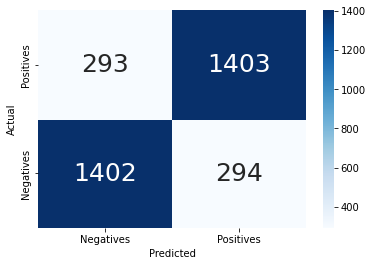

In [31]:
y_pred = lr.predict(x_test_bal)

# Call functions defined above to calculate metrics & plot a confusion matrix based on
# how well model simulates testing data
plot_cm(y_test_bal, y_pred);
lr_acc, lr_rec = bin_metrics(y_test_bal, y_pred)

We determined earlier that False Positives are less harmful than False Negatives. Thus, along with accuracy, which essentially measures how close the model is to the target, we should try to maximize recall. Luckily, recall is the highest-scoring metric for this model (recall = ~87%).<br><br>
Let's focus on accuracy, though, for a moment. Accuracy tells is the percent of correct predictions, whether precipitating or not. The Logistic Regression model, without any additional tuning, can correctly predict whether it's precipitating or not given a set of present atmospheric conditions around 84% of the time. 

#### 4. Check to see if the Logistic Regression model is overfitting (or underfitting)

A very important aspect of tuning machine learning model is to ensure the model isn't overfitting or underfitting.

![overfitting.v.underfitting](https://drive.google.com/uc?export=view&id=1cKNtqszFpzcLxPnNhSwHwvK_W_YGLfs1)

An underfit model is a biased model. Symptoms of underfitting are that your training data performs worse than your testing data, or the model metrics are just poor overall. To alleviate underfitting, introduce more variance into the model by adding more features, use ensemble methods, or increase model complexity. <br><br>
An overfit model means the model is fit very well to the training data, but fails to generalize predictions outside the training dataset. A symptom of overfitting is that the models' training accuracy is much better than the testing accuracy. Overfitting can happen more easily in more complex models, like neural networks. To alleviate overfitting, one needs to reduce variance, through **feature regularization**, lowering model complexity, or performing k-folds cross-validation.<br><br>
Before you dive too deeply into ML and in your own time, I suggest watching [this 6-minute StatQuest YouTube video](https://www.youtube.com/watch?v=EuBBz3bI-aA) to develop an intuition of error, overfitting, and underfitting.

In [32]:
# Compare testing data metrics to data training metrics.
print("Training metrics:")
pred_train= lr.predict(x_train_bal) 
bin_metrics(y_train_bal,pred_train);

# As a reminder, display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, y_pred);

Training metrics:
Accuracy: 0.8424
Recall: 0.8679
 
Testing metrics:
Accuracy: 0.8269
Recall: 0.8272


Remember:<br>
testing metrics > training metrics = underfitting, model is too simple<br>
testing metrics < training metrics = overfitting, model is too complex<br><br>

#### 5. Make a prediction with the Logistic Regression model

First, we randomly choose some atmospheric conditions using the function defined above. This will be the atmospheric conditions we use for all models we build.

In [33]:
origvals, testpredictor = rand_atmos_conditions_precip()
# print(origvals) # observation from original dataframe
# print(testpredictor) # scaled observation

In [34]:
# prediction output is in the format [probability no rain, probability rain]
lr_prediction = lr.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The meteorological conditions are: ")
print(origvals)
print(" ")
print(f"There is a {round(lr_prediction,2)}% chance of precipitation given those meteorological conditions.")

The meteorological conditions are: 
day             42452.000000
hour                0.291667
temp_F             29.700000
RH                 91.700000
dewtemp_F          27.600000
wind_mph           20.100000
wind_dir          340.000000
windgust           31.300000
windgust_dir      308.000000
pres_Hg           830.410000
SOLIN_Wm2           3.500000
Prec_inches         0.040000
prec_occur          1.000000
Name: 1975, dtype: float64
 
There is a 99.37% chance of precipitation given those meteorological conditions.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


<br><br><br>

## 2.1.B.b. [Random Forest](https://scikit-learn.org/stable/modules/ensemble.html#forest)

To understand random forests, one must first understand a [decision tree](https://scikit-learn.org/stable/modules/tree.html#tree). A decision tree is intuitive: it is essentially a flowchart to point to an outcome based on "decisions" for each feature. <br><br>
A Random Forest is an ensemble of decision trees that are randomly constructed based on the features of the dataset and number of decisions. Trees are constructed by randomly choosing a feature to "seed" each tree, and then making rules or associations with other features to lead to the specified outcome.

![random_forest](https://drive.google.com/uc?export=view&id=1Epldg87IF1Tu9-wTGOe5Rpp0Jvewwmrc)

In [35]:
from sklearn.ensemble import RandomForestClassifier
import time

#### 1. If you didn't perform for Logistic Regression above, perform a test-train split, perform feature scaling, and the rebalance our dataset. 
Otherwise, you can run this cell, but since I've specified the `random_state` to be the same as above, you should get the same set of data.

In [36]:
if 'x_train_bal' not in locals():
  x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=False, random_state=80305)

#### 2. Train (and tuning) the Random Forest model

#### Choosing hyperparameters

Typically, in Machine Learning models, we can choose a hyperparameters that control the behavior of the model and can improve model performance. These hyperparamters are just numbers that tell the model to act in different ways. Adjusting hyperparameters can control the complexity of the model, and thus, influence model metrics. <br><br>
There are many hyperparameters one can decide upon when tuning the Random Forest classifier (see scikit-learn page on Random Forests for more examples). The two we will be adjusting is 
1. The number of estimators or "trees" in the forest
2. The depth of the tree, or how many "decisions" are made until convergence is reached. 

In [37]:
acc_scores = []
rec_scores = []

num_est = [10, 50, 500] # number of trees
depth = [2, 10, 100] # number of decisions
for i in num_est:
    start = time.time()
    print("Number of estimators is "+str(i))

    for k in depth:
        print("depth is "+str(k))
        forest = RandomForestClassifier(n_estimators=i, max_depth=k)
        forest.fit(x_train_bal, y_train_bal)
        
        # cross validate & evaluate metrics based on testing data
        pred_test= forest.predict(x_test_bal)
        acc_val = metrics.accuracy_score(y_test_bal, pred_test)
        acc_scores.append(acc_val)
        rec_val = metrics.recall_score(y_test_bal, pred_test)
        rec_scores.append(rec_val)

    end = time.time()
    print("Random Forest took "+str(end-start)+" seconds.")

Number of estimators is 10
depth is 2
depth is 10
depth is 100
Random Forest took 0.4432556629180908 seconds.
Number of estimators is 50
depth is 2
depth is 10
depth is 100
Random Forest took 1.9477124214172363 seconds.
Number of estimators is 500
depth is 2
depth is 10
depth is 100
Random Forest took 18.94938564300537 seconds.


Max Accuracy (black): 0.8373
Max Recall (blue): 0.8202


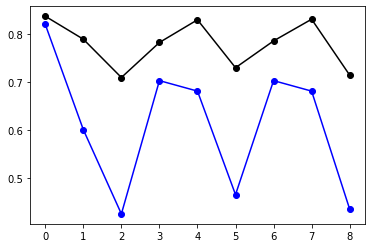

In [38]:
plt.plot(acc_scores, marker='o', color='black')
plt.plot(rec_scores, marker='o', color='blue')
print("Max Accuracy (black):", round(max(acc_scores), 4))
print("Max Recall (blue):", round(max(rec_scores), 4))

**x =** <br>
0, 1, 2: number of estimators = 10<br>
3, 4, 5: number of estimators = 50<br>
6, 7, 8: number of estimators = 500<br>
<br>
0, 3, 6: depth range = 2<br>
1, 4, 7: depth range = 10<br>
2, 5, 8: depth range = 100<br>

Choosing the right hyperparameters for this model requires revisiting which metrics are most important to our question. We want to maximize both recall and accuracy. <br><br>
For simplicity, I choose the parameters corresponding to x=0, but __I highly suggest you try other combinations of parameters as well__.

In [39]:
forest = RandomForestClassifier(n_estimators=10, max_depth=2);
forest.fit(x_train_bal, y_train_bal);

#### 3. Assess the Random Forest's performance using testing data

Once again, we will use our testing data to make an initial evaluation of how the model is doing.

Accuracy: 0.8255
Recall: 0.7541


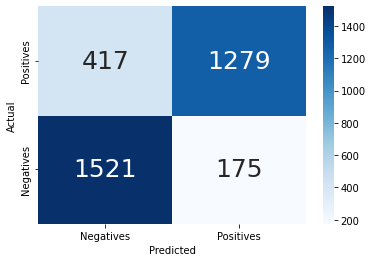

In [40]:
pred_test= forest.predict(x_test_bal)

# Call functions defined above to calculate metrics & plot a confusion matrix based on
# how well model simulates testing data
forest_acc, forest_rec = bin_metrics(y_test_bal, pred_test)
plot_cm(y_test_bal, pred_test)

#### 4. Check to see if the Random Forest is overfitting

In [41]:
# Compare testing data metrics to data training metrics.
print("Training metrics:")
rf_pred_train= forest.predict(x_train_bal) 
bin_metrics(y_train_bal,rf_pred_train);

# As a reminder, display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, pred_test);

Training metrics:
Accuracy: 0.8434
Recall: 0.8134
 
Testing metrics:
Accuracy: 0.8255
Recall: 0.7541


Remember:<br>
testing metrics > training metrics = underfitting, model is too simple<br>
testing metrics < training metrics = overfitting, model is too complex

Random forests seldom overfit, but if they do, one should try increasing the number of trees, or decreasing the amount of data used to construct each tree. See scikit-learn's [Random Forest Classifier webpage](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for information on more hyperparameters one can tune to address overfitting.

#### 5. Make a prediction with the Random Forest

In [42]:
# prediction output is in the format [probability no rain, probability rain]
forest_prediction = forest.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The meteorological conditions are: ")
print(origvals)
print(" ")
print("There is a {0:.{digits}f}% chance of precipitation given those meteorological conditions.".format(forest_prediction, digits=2))

The meteorological conditions are: 
day             42452.000000
hour                0.291667
temp_F             29.700000
RH                 91.700000
dewtemp_F          27.600000
wind_mph           20.100000
wind_dir          340.000000
windgust           31.300000
windgust_dir      308.000000
pres_Hg           830.410000
SOLIN_Wm2           3.500000
Prec_inches         0.040000
prec_occur          1.000000
Name: 1975, dtype: float64
 
There is a 82.21% chance of precipitation given those meteorological conditions.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


*The random forest yields yet another percent chance of precipitation given the meteorological conditions... hmm...*

<br><br><br>

## 2.1.B.c. [Neural Network](https://blog.insightdatascience.com/a-quick-introduction-to-vanilla-neural-networks-b0998c6216a1)
![neuarl net chart](https://drive.google.com/uc?export=view&id=1dGiM6CMR0kKSh2kVe9N3e_WBdCCzjweq)
![neural net equation](https://drive.google.com/uc?export=view&id=1QsWJbcry5SQqalXu3gKwcH9phE98lEOQ)


*Note: there is a TON of information online about Neural Networks.* I suggest starting with the 3-part blog series on neural networks accessible in the link above for a gentle introduction to the theory. <br><br>
If you'd rather absorb new information through watching a video, I found [this three-part series of youtube videos](https://www.youtube.com/watch?v=aircAruvnKk) (totaling about an hour in length) to be very helpful.<br><br>
Another great resource is [machinelearningmastery.com](machinelearningmastery.com). In fact, the model below is based off of [this blog post](https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/). 

In [43]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#### 1. Perform a test-train split, perform feature scaling, and the rebalance our dataset.

Split test & training data, perform feature scaling, and rebalance dataset according to outcomes if you didn't do so above.

In [44]:
if 'x_train_bal' not in locals():
  x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=False, random_state=80305)

#### 2. Train (and build and compile) the Neural Network

There are lots of hyperparameters here. Please read the comments to guide you in playing with them later!

#### Build a very simple Neural Network & compile

In [45]:
number_inputs = len(x_train_bal.columns)

# create model
nn = Sequential()
nn.add(Dense(number_inputs, input_dim=number_inputs, activation='relu'))

# Try uncommenting this to address overfitting
# from keras.regularizers import l2
# reg = l2(0.001)
# nn.add(Dense(number_inputs, activation='relu',bias_regularizer=reg,activity_regularizer=reg))

# try commenting out one and then the other
nn.add(Dense(1, activation='sigmoid'))
#nn.addDense(1, activation='softmax'))

# Compile model 
# Also try changing the learning rate.
learning_rate = 0.001 # only used in the SGD optimizer.

# Also try commenting out one & then the other. 
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
#nn.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=learning_rate), metrics=['accuracy']) 

*Note: the `binary_crossentropy` is also called the "Log Loss". This is a loss function specific for predicting two classes. 
$$L_{BCE} = -\frac{1}{n}\sum{(Y_{i}⋅ log(\hat{Y_{i}}) + (1-Y_{i})⋅ log(1-\hat Y_{i})} $$, where $Y_{i}$ and $\hat{Y_{i}}$ is the actual and the model's predicted probability of one class, respectively.*

#### Actually training the model.

In [46]:
batch_size = 24 # The number of samples the network sees before it backpropagates (batch size) # 24 & 32 yield accuracy = 87%
epochs = 100 # The number of times the network will loop through the entire dataset (epochs)
shuffle = True # Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 # Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

# Train the neural network!
start = time.time()

history = nn.fit(x_train_bal, y_train_bal, validation_data=(x_test_bal, y_test_bal), 
          batch_size=batch_size, epochs=epochs, shuffle=shuffle, verbose=verbose)

end = time.time()
print("Neural Network took "+str(end-start)+" seconds to train.")

Epoch 1/100
568/568 - 2s - loss: 0.6370 - accuracy: 0.6735 - val_loss: 0.5603 - val_accuracy: 0.7535 - 2s/epoch - 4ms/step
Epoch 2/100
568/568 - 1s - loss: 0.5201 - accuracy: 0.7623 - val_loss: 0.4935 - val_accuracy: 0.7904 - 1s/epoch - 2ms/step
Epoch 3/100
568/568 - 1s - loss: 0.4633 - accuracy: 0.7962 - val_loss: 0.4606 - val_accuracy: 0.8069 - 900ms/epoch - 2ms/step
Epoch 4/100
568/568 - 1s - loss: 0.4303 - accuracy: 0.8154 - val_loss: 0.4449 - val_accuracy: 0.8205 - 1s/epoch - 2ms/step
Epoch 5/100
568/568 - 1s - loss: 0.4103 - accuracy: 0.8298 - val_loss: 0.4293 - val_accuracy: 0.8128 - 909ms/epoch - 2ms/step
Epoch 6/100
568/568 - 1s - loss: 0.3958 - accuracy: 0.8355 - val_loss: 0.4188 - val_accuracy: 0.8022 - 910ms/epoch - 2ms/step
Epoch 7/100
568/568 - 1s - loss: 0.3847 - accuracy: 0.8380 - val_loss: 0.4122 - val_accuracy: 0.8193 - 1s/epoch - 2ms/step
Epoch 8/100
568/568 - 1s - loss: 0.3756 - accuracy: 0.8419 - val_loss: 0.4043 - val_accuracy: 0.8219 - 877ms/epoch - 2ms/step
Epoc

#### Accuracy & loss with epochs
Neural networks train in __epochs__. During each epoch, the model trains by sweeping over each layer, adjusting weights based on their resulting errors, through processes called __forward propagation__ and __backpropagation__. By plotting the model accuracy & loss which each epoch, we can visualize how the model error evolves with training.

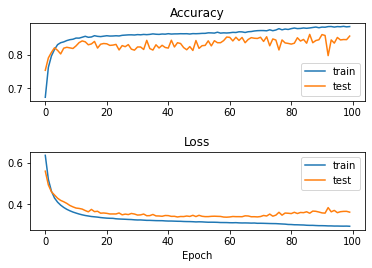

In [47]:
figure, axes = plt.subplots(nrows=2,ncols=1)
figure.tight_layout(pad=3.0)

# plot accuracy during training
plt.subplot(211)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend();

# plot loss during training
plt.subplot(212)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epoch");
plt.legend()
plt.show();

#### 3. Assess Neural Network's performance using testing data

Though the accuracy is pictured above, additionally quantify recall on testing data with the same functions used previously to remain consistent

Accuracy: 0.8552
Recall: 0.8361


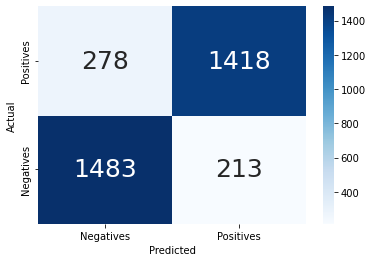

In [48]:
pred_test= (nn.predict(x_test_bal)>0.5).astype("int32")
nn_acc, nn_rec = bin_metrics(y_test_bal, pred_test)
plot_cm(y_test_bal, pred_test)

#### 4. Check to see if the Neural Network is overfitting

In [49]:
# Compare testing data metrics to data training metrics.
print("Training metrics:")
nn_pred_train= (nn.predict(x_train_bal)>0.5).astype("int32")
bin_metrics(y_train_bal,nn_pred_train);

# As a reminder, display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, pred_test);

Training metrics:
Accuracy: 0.8893
Recall: 0.9231
 
Testing metrics:
Accuracy: 0.8552
Recall: 0.8361


Neural networks can easily overfit because they are very complex and can fit to the training data extremely well,  which prevents them from generalizing to other data (like the testing data). 

#### 5. Make a prediction with the Neural Network

In [50]:
# prediction output is in the format [probability no rain, probability rain]
nn_prediction = nn.predict(np.array(testpredictor).reshape(1, -1))[0][0]*100
print("The meteorological conditions are: ")
print(origvals)
print("There is a {0:.{digits}f}% chance of precipitation given those meteorological conditions.".format(nn_prediction, digits=2))

The meteorological conditions are: 
day             42452.000000
hour                0.291667
temp_F             29.700000
RH                 91.700000
dewtemp_F          27.600000
wind_mph           20.100000
wind_dir          340.000000
windgust           31.300000
windgust_dir      308.000000
pres_Hg           830.410000
SOLIN_Wm2           3.500000
Prec_inches         0.040000
prec_occur          1.000000
Name: 1975, dtype: float64
There is a 98.74% chance of precipitation given those meteorological conditions.


*Interesting... How does the Neural Network's estimate of %chance precip compare to that of the other models? See below for final intermodel comparison.*

<br><br>

---------------------------------------------

# Final intermodel comparison

In [51]:
model_metrics = pd.DataFrame({'Metrics':['Accuracy','Recall','Prediction example'],
    'Logistic Regression':[lr_acc, lr_rec, lr_prediction],
    'Random Forest':[forest_acc, forest_rec, forest_prediction],
    'Neural Network':[nn_acc, nn_rec, nn_prediction]})
model_metrics = model_metrics.set_index('Metrics')
model_metrics

,Logistic Regression,Random Forest,Neural Network
Metrics,,,
Accuracy,0.826946,0.825472,0.855248
Recall,0.827241,0.754127,0.836085
Prediction example,99.371736,82.207660,98.743999


<br><br>

---------------------------------------------

# Feature Importance

The code below shows the way one would identify the most important features in each model, i.e., the best predictors of rainfall. The code looks a little different from model to model.

In [52]:
# If you want to look at the pre-scaled data used in the models, uncomment the line below
#x

#### Feature Importance in Logistic Regression:

Luckily, feature importance in linear models is usually quite easy to obtain. 

In [53]:
pd.DataFrame(abs(lr.coef_[0]),
             index = x.columns,
             columns=['importance']).sort_values('importance',ascending=False)

,importance
RH,9.312343
windgust,9.039281
temp_F,2.496216
SOLIN_Wm2,1.775145
dewtemp_F,1.392580
pres_Hg,0.988113
wind_mph,0.358548
windgust_dir,0.228812
wind_dir,0.149672


#### Finding most important features in a Random Forest model

There are a number of different ways to calculate feature importance in tree-based algorithms. We are using the default feature importance algorithm here found in the Random Forest package, which are **Gini importance**. In some instances, [Gini Importance can falseley put too much importance on some features if the model is overfitting](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html). Some find that **permutation importance** or, better yet, [**SHAP values**](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html) are a more robust way to derive feature importances (albeit more costly and perhaps a little more difficult to understand). <br><br>
*Side note: the site linked above that documents the python package for calculating SHAP values [provides a nice warning](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%C2%A0insights.html) about overinterpreting the results of feature importance!*

In [54]:
pd.DataFrame(forest.feature_importances_,
                                   index = x.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

,importance
RH,0.317248
dewtemp_F,0.205172
temp_F,0.184268
wind_mph,0.131891
wind_dir,0.081676
windgust,0.079744
windgust_dir,0.000000
pres_Hg,0.000000
SOLIN_Wm2,0.000000


#### Neural Network feature importance

Feature importance from Neural Nets is not so straightforward. The approach implemented below makes a prediction for each feature - setting each feature to equal 1 and the rest to 0, and repeating fo reach feature. 

In [55]:
df['temp_F']

0        7.0
1        5.4
2        6.4
3        3.0
4        3.7
        ... 
8779    22.3
8780    20.3
8781    19.9
8782    17.8
8783    16.3
Name: temp_F, Length: 8784, dtype: float64

In [56]:
cols = x.columns.values
nn_featimportance = []
for var in cols:
    # create a vector corresponding to a 1 where the feature is located:
    inputvector = np.array((cols==var).astype(int).reshape(1, -1))
    nn_featimportance.append(nn.predict(inputvector)[0][0]*100)

In [57]:
pd.DataFrame( nn_featimportance,
             index = x.columns,
             columns=['importance']).sort_values('importance',ascending=False)

,importance
RH,15.151459
windgust,1.834247
SOLIN_Wm2,0.614268
wind_mph,0.052896
windgust_dir,0.002039
dewtemp_F,0.000528
wind_dir,0.000315
temp_F,0.000045
pres_Hg,0.000006


<br><br><br>

---------------------------------------------

# Questions

In [59]:
import sys
sys.path.append('/content/drive/MyDrive/ATOC5860/ATOC5860_Spring2022_share/applicationlab6/')
from solutions import supervised

1. __One important "gotcha" in ML is the order of data preparation. Why should one should perform the train-test split *before* feature scaling and rebalancing? *Hint: think about using a trained model for future predictions. Why perform a test-train split at all? Also, what data is considered when scaling a dataset?*__

In [60]:
supervised.answer1()

Let's say you perform feature scaling before the train-test split. This means the scaling of the unseen data (the testing data) *depends on* the training data. <br><br>Now, imagine you are provided the model trained on this data from an external source. You'd like to use the model to determine if some meteorological conditions are going to produce rain. Since the data used to train the model depends on the outcome you're trying to predict, neither you nor the model knows how to scale the new input data in such a way that the model can make an educated guess. The model is unable to contextualize the unseen data. The importance of the order of data preparation is why building *__data preparation pipelines__* is so important in using Machine Learning. The 'gotcha' described above - i.e., performing a test-train split *after* other data preparation - is called *__data leakage__*.

2. __Why did we choose to use accuracy, recall, and predicted precipitation probability as a way to compare models?__

In [61]:
supervised.answer2()

No one likes an incorrect weather forecast, but people are probably more upset when the forecast calls for a sunny day and it ends up raining. In our case, that means the model would be predicting no precipitation when there actually is precipitation - a false negative. Revisit the equations for accuracy & recall in section 2.1.B, Q7 above. Accuracy and recall contain the number of false negatives in the denominator. Thus, maximizing these metrics require minimizing the number of false negatives. <br><br>Predicted precipitation probability provides a sanity test for us to make sure the model isn't way off base. It allows us to see for ourselves: given X meteorological conditions and our own understanding of meteorology, would rain seem likely? Is the model actually doing something realistic?

3. __Now that you have some exposure to various models, what do you think might be some pros and cons regarding each model?__

In [62]:
supervised.answer3()

<br>1. __Logistic regression__ tends to overgeneralize or underfit data, but is easy to implement, to understand and easy to back out feature importance.<br>2. __Singular Vector Machines__ are great at capturing complex relationships, but cannot back out feature importance. Plus, the use of the kernel makes them hard to interpret.<br>3. __Random forests__ are easier to understand, generally do not overfit, and can capture complex relationships, and can provide feature importance, but they can be slow to train and there are a lot of hyperparameters to choose from.<br>4. __Neural Networks__ are great at capturing complex relationships. But they are slow to train and are susceptible to overfitting.

4. __Collinearity, or non-zero correlation among features, results in a model that is overly complex, reduces the statistical significance of the fit of the model, and prevents one from correctly identifying the importance of features. Are there features included in these models that are collinear? You may assess this by running the code below. If so, how do you think we should address collinearity?__

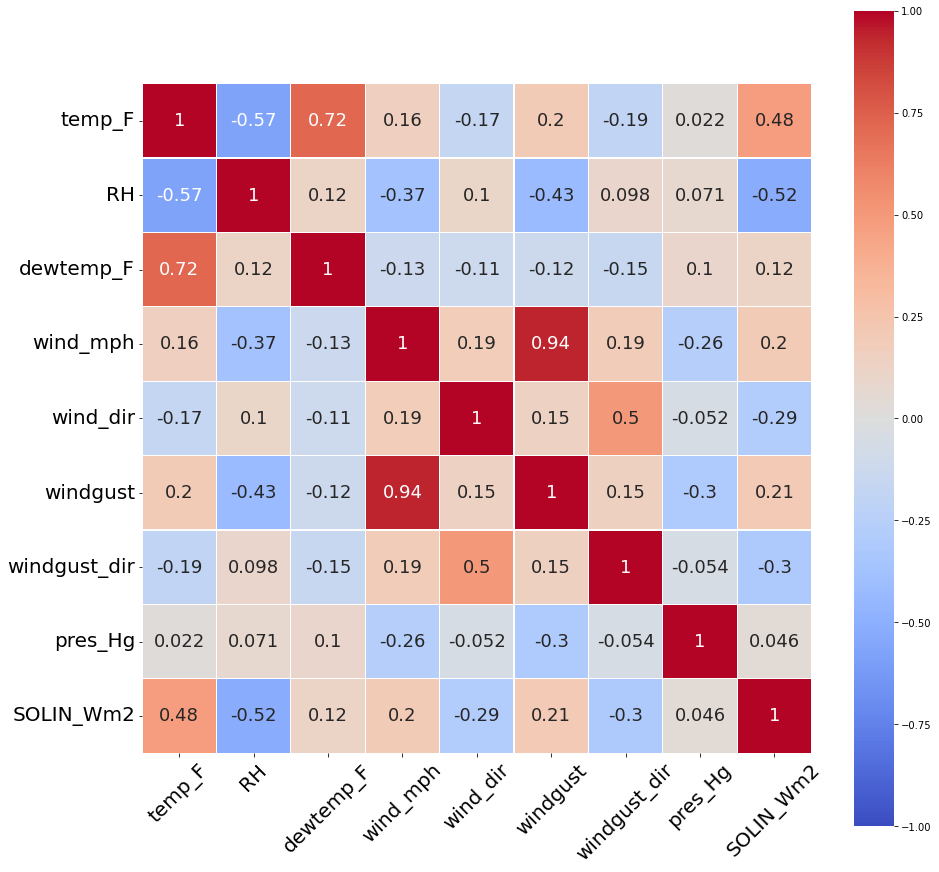

In [63]:
plt.figure(figsize=[15, 15])
ax = sns.heatmap(x.corr(), cmap='coolwarm', annot=True, linewidths=0.2, square=True, vmin=-1, vmax=1,annot_kws={"size": 18});
plt.xticks(fontsize=20,rotation=45);
plt.yticks(fontsize=20,rotation=0);

In [64]:
supervised.answer4()

First, we should assess which features are collinear. If we don't have that many features, we could use our meteorological expertise to simply remove one of the features that shares collinearity with other features. Another way to address collinearity is to use **feature regularization**, or add weights that penalize features that add noise, ultimately reducing model complexity.<br><br>Below, I try re-training the Random Forest model after removing wind_mph, wind_dir, dewtemp_F, windgust_dir, and SOLIN_Wm2.<br><br>

'Uncomment & run %load collinearity_solution.py below'

In [65]:
# !python "/content/drive/MyDrive/ATOC5860/ATOC5860_Spring2022_share/applicationlab6/collinearity_solution.py"

5. __Above, we selected on subset of the data to be the testing dataset, and the remaining data to be our training data. Can you think of any issues with this approach__?

In [66]:
supervised.answer5()

There are two glaring issues with this approach. To start, we are not using the full set of data to train. This dataset is only a few thousand observations, and while that may seem like a lot - remember that we had to *oversample* in order to add more examples of rainy days to our dataset. We want to make sure we use as much data as possible to train our model! Instead, we should have used K-folds cross validation - i.e., cycle through the entire dataset and train the models repeatedly over different subsections of the data.<br><br>Additionally, we have no **validation** dataset. When comparing models, it's ideal to have a holdout dataset that you don't use to train, but instead, you use in order to evaluate and compare models. It should be the same exact set of observations that each model makes a prediction over in order to obtain an apples-to-apples comparison. It is the error over the holdout validation dataset that should be reported.

6. __For fun:__
    - __Try a different set of parameters for the random forest. How do the metrics change? Does the model overfit?__
    - __Try playing around with the neural network to see what happens. You can change the optimizer, the batch size, the number of epochs, the activation function of the last layer, and the learning rate. How do the metrics change? Does the model overfit? Do you run into errors?__